In [1]:
import mne, os
import pickle
import numpy as np 
import pandas as pd
import time

path = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/'

# Specify the custom filename from which you want to load the pickle file
file_name = path + 'S12dataStill.pickle'
file_name2 = path + 'S12datamovieNoCatch.pickle'

# Use the pickle.load() method to load the 'Epochs' object from the custom filename
with open(file_name, 'rb') as file:
    S12_stacked = pickle.load(file)

with open(file_name2, 'rb') as file:
    S12_stackedMovie = pickle.load(file)




In [2]:
epochs_stacked = S12_stacked
epochs_stackedMovie = S12_stackedMovie

In [3]:
# add metadata
block_type = [k.split('/')[1] for k in epochs_stacked.event_id.keys()]
condition = [k.split('/')[2] for k in epochs_stacked.event_id.keys()]
n_runs = 4
n_trials = 160

df = pd.DataFrame()
df['block_type'] = [block_type[i-1] for i in epochs_stacked.events[:,2]]
df['condition'] = [condition[i-1] for i in epochs_stacked.events[:,2]]
df['run_nr'] = np.repeat(np.arange(n_runs),n_trials)

S12_stacked.metadata = df.copy()

Adding metadata with 3 columns


In [7]:
print(epochs_stacked._data.shape)

(640, 269, 961)


In [4]:
epochs_stacked

<EpochsArray | 640 events (all good), -0.2 – 0.6 s (baseline -0.2 – 0 s), ~1.23 GB, data loaded, with metadata,
 'S01/Watch_Still/Center': 80
 'S01/Watch_Still/45_Right': 80
 'S01/Watch_Still/Right': 80
 'S01/Watch_Still/135_Right': 80
 'S01/Watch_Still/Back': 80
 'S01/Watch_Still/135_Left': 80
 'S01/Watch_Still/Left': 80
 'S01/Watch_Still/45_Left': 80>

In [8]:
epochs_stackedMovie._data.shape

(448, 269, 4081)

In [9]:
S12_stacked.metadata

block_type  condition  run_nr
0    Watch_Still   45_Right       0
1    Watch_Still    45_Left       0
2    Watch_Still   135_Left       0
3    Watch_Still     Center       0
4    Watch_Still       Left       0
..           ...        ...     ...
731  Watch_Still    45_Left       3
732  Watch_Still       Left       3
733  Watch_Still       Back       3
734  Watch_Still  135_Right       3
735  Watch_Still     Center       3

[640 rows x 3 columns]

In [10]:
block_type = [k.split('/')[1] for k in epochs_stackedMovie.event_id.keys()]
condition = [k.split('/')[2] for k in epochs_stackedMovie.event_id.keys()]

# Define the number of trials for each run (uneven distribution)
trials_per_run = [112, 112, 112, 112]  # Adjust these values as needed

# Verify that the total number of trials matches the sum of trials_per_run
if sum(trials_per_run) == len(epochs_stackedMovie.events):
    df = pd.DataFrame()
    run_nr = []
    for run, num_trials in enumerate(trials_per_run):
        run_nr.extend([run] * num_trials)
    
    df['block_type'] = [block_type[i-1] for i in epochs_stackedMovie.events[:, 2]]
    df['condition'] = [condition[i-1] for i in epochs_stackedMovie.events[:, 2]]
    df['run_nr'] = run_nr

    epochs_stackedMovie.metadata = df.copy()
    print("Metadata has been added to epochs_stacked.")
else:
    print("Total number of trials does not match the sum of trials_per_run.")

Adding metadata with 3 columns
Metadata has been added to epochs_stacked.


In [11]:
print(epochs_stackedMovie.metadata)

      block_type   condition  run_nr
0    Watch_Still   0247_Left       0
1    Watch_Still   0202_Left       0
2    Watch_Still  0067_Right       0
3    Watch_Still   0022_Left       0
4    Watch_Still   0292_Left       0
..           ...         ...     ...
499  Watch_Still  0202_Right       3
500  Watch_Still  0022_Right       3
501  Watch_Still   0247_Left       3
502  Watch_Still   0202_Left       3
503  Watch_Still   0292_Left       3

[448 rows x 3 columns]


In [12]:
print(epochs_stacked.metadata['condition'].unique())

['45_Right' '45_Left' '135_Left' 'Center' 'Left' 'Right' '135_Right'
 'Back']


#### Within decoding (time-series & time-gen)

loop: 24.317326068878174


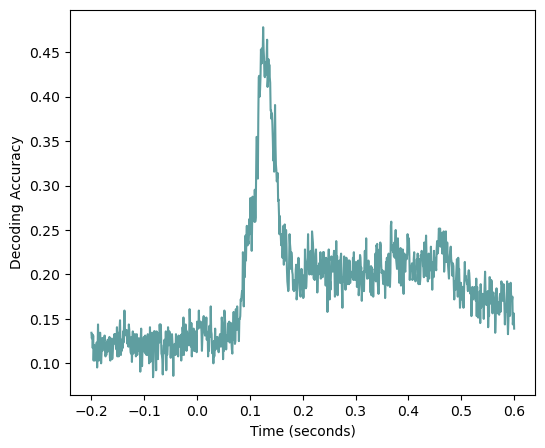

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

def select_conditions(epochs_stacked,column_name,items_to_select):
    if type(items_to_select)==list:
        selected_epochs = epochs_stacked[np.any([epochs_stacked.metadata[column_name] == i  for i in items_to_select],axis=0)]
    if type(items_to_select)==str:
        selected_epochs = epochs_stacked[epochs_stacked.metadata[column_name] == items_to_select]
    return selected_epochs

def train_test_split(epo_stacked,test_run):
    epochs_test=epo_stacked[f'run_nr == {test_run}']
    y_test = epochs_test.metadata['condition'].to_numpy()
    x_test = epochs_test._data

    epochs_train=epo_stacked[f'run_nr != {test_run}']
    y_train = epochs_train.metadata['condition'].to_numpy()
    x_train = epochs_train._data

    return x_train, x_test, y_train, y_test

def run_decoding(x_train,y_train,x_test,y_test):
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('classifier', svm.SVC(kernel='linear',C=1))])
    pipe.fit(x_train,y_train)
    predictions = pipe.predict(x_test)
    accuracy = predictions == y_test

    return np.mean(accuracy)

def run_timeseries_decoding(epochs_selected,test_run):
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    cv_res = Parallel(n_jobs=48, prefer="threads")(delayed(run_decoding)(x_train[:,:,t],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_selected.times)))
    return cv_res


## WITHIN DECODING: simple timeseries
# THIS IS TOO SLOW
# program_starts = time.time()
# epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')
# res = Parallel(n_jobs=48, prefer="threads")(delayed(run_timeseries_decoding)(select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still'), test_run) for test_run in np.unique(epochs_selected.metadata.run_nr))
# time_series_results = np.mean(np.array(res),axis=0)
# print("parallel: {0}".format(time.time() - program_starts))


#Write a code with dictionary specifying all condition types I care about 
#Or pandas data file with each condition & accuracies
program_starts = time.time()
accuracy = []
epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')
for test_run in np.unique(epochs_selected.metadata.run_nr):
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    accuracy.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding)(x_train[:,:,t],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_stacked.times))))
print("loop: {0}".format(time.time() - program_starts))

plt.figure(figsize=(6, 5))
plt.xlabel('Time (seconds)')
plt.ylabel('Decoding Accuracy')
plt.plot(epochs_stacked.times, np.mean(np.array(accuracy),axis=0), color = '#5F9EA0')


## WITHIN DECODING: time-generalization
epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')

def run_timegen(epochs_selected,test_run):
    results_matrix = np.zeros((len(epochs_selected.times), len(epochs_selected.times)))
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    for training_tp in range(len(epochs_selected.times)):
        res = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding)(x_train[:,:,training_tp],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_selected.times)))
        results_matrix[training_tp,:] = res
    return results_matrix

# accuracy = []
# for test_run in np.unique(epochs_selected.metadata.run_nr):
#     accuracy.append(run_timegen(epochs_selected,test_run))
# time_gen_results = np.mean(np.array(accuracy),axis=0)
# plt.plot(time_gen_results)


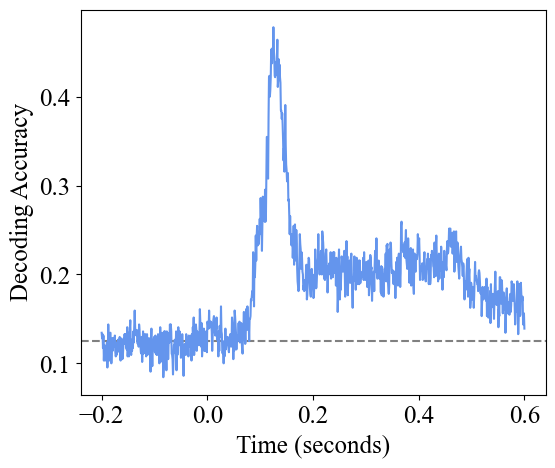

In [14]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.figure(figsize=(6, 5))
plt.xlabel('Time (seconds)')
plt.ylabel('Decoding Accuracy')
plt.axhline(y=.125, color='grey', linestyle='--', label='chance')
plt.plot(epochs_stacked.times, np.mean(np.array(accuracy),axis=0), color = '#6495ED')

In [49]:
epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')

accuracy = []
for test_run in np.unique(epochs_selected.metadata.run_nr):
    matrix = run_timegen(epochs_selected, test_run)
    accuracy.append(matrix)

In [50]:
print(len(accuracy[0][1]))

961


In [51]:
average_array = np.mean(accuracy, axis=0)

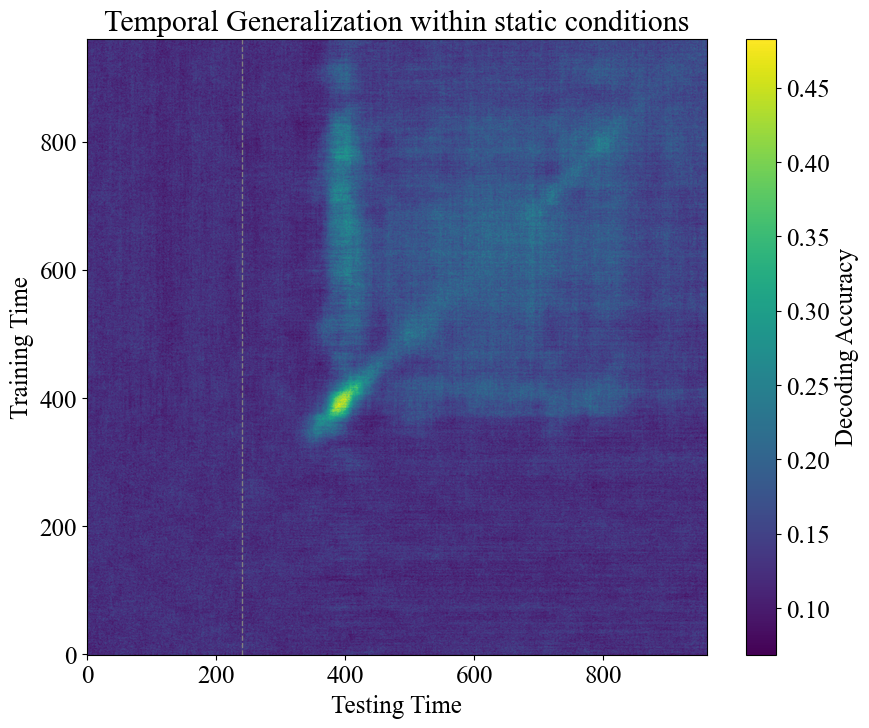

In [59]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 8))
plt.imshow(average_array, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Decoding Accuracy')
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.axvline(x=240, color='gray', linestyle='--', linewidth=1)
plt.title('Temporal Generalization within static conditions')
plt.show()

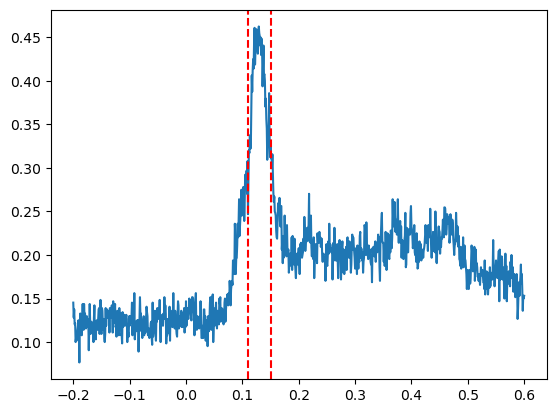

In [184]:
plt.plot(epochs_stacked.times, np.mean(np.array(accuracy),axis=0))
plt.axvline(x=.11, color='red', linestyle='--', label='Time 0.1')
plt.axvline(x=.15, color='red', linestyle='--', label='Time 0.1')

### Cross-decoding ()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


#Average across or pick time points and then test for each time point 
specifyTime = True

def select_conditions(epochs_stacked,column_name,items_to_select):
    if type(items_to_select)==list:
        selected_epochs = epochs_stacked[np.any([epochs_stacked.metadata[column_name] == i  for i in items_to_select],axis=0)]
    if type(items_to_select)==str:
        selected_epochs = epochs_stacked[epochs_stacked.metadata[column_name] == items_to_select]
    return selected_epochs

def train_test_split_cross(epo_stacked, epo_stackedMovie, test_condition, start_time, end_time):
    epochs_test=epo_stackedMovie[epo_stackedMovie.metadata['condition'] == test_condition]
    y_test = epochs_test.metadata['condition'].to_numpy()
    x_test = epochs_test._data
    #x_test = x_test[100:500:]
    x_test.shape
    epochs_train=epo_stacked[epo_stacked.metadata['block_type'] == 'Watch_Still']
    y_train = epochs_train.metadata['condition'].to_numpy()
    mask = (epochs_train.times >= start_time) & (epochs_train.times <= end_time)


    if specifyTime == True:
        mask = (epochs_train.times >= start_time) & (epochs_train.times <= end_time)
        x_train = np.mean(epochs_train._data[:,:,mask], axis = 2)

    else:
        x_train = epochs_train._data
    return x_train, x_test, y_train, y_test

def run_decoding_cross(x_train,y_train,x_test):
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('classifier', svm.SVC(kernel='linear',C=1))])
    pipe.fit(x_train,y_train)
    #Step where I average at each sensor weight, would need to loop around fit for each time point
    #And then I would let it return the weight matrix, and apply an average of the weights to the testing data
    predictions = pipe.predict(x_test)
    return predictions

In [16]:
def find_contacting_movies_and_samples(input_number, movies):
    def normalize_frame(frame):
        """Normalize frame to be within 0 to 359."""
        return frame % 360

    def frames_contact(movie_start, input_number):
        """Check if a movie intersects the input number."""
        right_frames = [(movie_start + i) % 360 for i in range(181)]
        left_frames = [(movie_start - i) % 360 for i in range(181)]
        left_frames = [normalize_frame(f) for f in left_frames]

        return input_number in right_frames, input_number in left_frames

    def calculate_sample_time(movie_start, input_number, direction):
        """Calculate the sample time at which the movie passes through the input number."""
        if direction == "Right":
            frame_difference = (input_number - movie_start) % 360
        else:  # direction == "Left"
            frame_difference = (movie_start - input_number) % 360
        
        if frame_difference == 0:
            return 60
        else:
            return 60 + frame_difference * 20

    result = {}
    for movie_start in movies:
        right_contacts, left_contacts = frames_contact(movie_start, input_number)
        
        if right_contacts:
            if movie_start < 100: #Ensure correct naming, movies less than 100 have two zeros in front of them in condition name
                movie_name = f"00{movie_start}_Right"
            else:
                movie_name = f"0{movie_start}_Right"
            sample_time = calculate_sample_time(movie_start, input_number, "Right") + 240
            result[movie_name] = sample_time
        
        if left_contacts:
            if movie_start < 100:
                movie_name = f"00{movie_start}_Left"
            else:
                movie_name = f"0{movie_start}_Left"
            sample_time = calculate_sample_time(movie_start, input_number, "Left") + 240
            result[movie_name] = sample_time

    return result

# Example usage:
input_number = [0, 45, 90, 135, 180, 225, 270, 315]
movies = [22, 67, 122, 157, 202, 247, 292, 337]  # List of starting frames for movies
result_list = []

for i in input_number:
    result_list.append(find_contacting_movies_and_samples(i, movies))


In [17]:
print(result_list)

[{'0022_Left': 740, '0067_Left': 1640, '0122_Left': 2740, '0157_Left': 3440, '0202_Right': 3460, '0247_Right': 2560, '0292_Right': 1660, '0337_Right': 760}, {'0022_Right': 760, '0067_Left': 740, '0122_Left': 1840, '0157_Left': 2540, '0202_Left': 3440, '0247_Right': 3460, '0292_Right': 2560, '0337_Right': 1660}, {'0022_Right': 1660, '0067_Right': 760, '0122_Left': 940, '0157_Left': 1640, '0202_Left': 2540, '0247_Left': 3440, '0292_Right': 3460, '0337_Right': 2560}, {'0022_Right': 2560, '0067_Right': 1660, '0122_Right': 560, '0157_Left': 740, '0202_Left': 1640, '0247_Left': 2540, '0292_Left': 3440, '0337_Right': 3460}, {'0022_Right': 3460, '0067_Right': 2560, '0122_Right': 1460, '0157_Right': 760, '0202_Left': 740, '0247_Left': 1640, '0292_Left': 2540, '0337_Left': 3440}, {'0022_Left': 3440, '0067_Right': 3460, '0122_Right': 2360, '0157_Right': 1660, '0202_Right': 760, '0247_Left': 740, '0292_Left': 1640, '0337_Left': 2540}, {'0022_Left': 2540, '0067_Left': 3440, '0122_Right': 3260, '015

In [20]:
# Create four lists to store the separated dictionaries
list_1 = []
list_2 = []
list_3 = []
list_4 = []

# Process each dictionary in result_list
for original_dict in result_list:
    # Sort the dictionary items by their values (ascending)
    sorted_items = sorted(original_dict.items(), key=lambda item: item[1])
    
    # Create new dictionaries for each list based on the sorted values
    dict_1 = dict(sorted_items[:2])  # Lowest 2 values
    dict_2 = dict(sorted_items[2:4])  # Second lowest 2 values
    dict_3 = dict(sorted_items[4:6])  # Third lowest 2 values
    dict_4 = dict(sorted_items[6:])   # Remaining values
    
    # Append the new dictionaries to the respective lists
    list_1.append(dict_1)
    list_2.append(dict_2)
    list_3.append(dict_3)
    list_4.append(dict_4)

# Print the results for verification
print("List 1:", list_1)
print("List 2:", list_2)
print("List 3:", list_3)
print("List 4:", list_4)

List 1: [{'0022_Left': 740, '0337_Right': 760}, {'0067_Left': 740, '0022_Right': 760}, {'0067_Right': 760, '0122_Left': 940}, {'0122_Right': 560, '0157_Left': 740}, {'0202_Left': 740, '0157_Right': 760}, {'0247_Left': 740, '0202_Right': 760}, {'0292_Left': 740, '0247_Right': 760}, {'0337_Left': 740, '0292_Right': 760}]
List 2: [{'0067_Left': 1640, '0292_Right': 1660}, {'0337_Right': 1660, '0122_Left': 1840}, {'0157_Left': 1640, '0022_Right': 1660}, {'0202_Left': 1640, '0067_Right': 1660}, {'0122_Right': 1460, '0247_Left': 1640}, {'0292_Left': 1640, '0157_Right': 1660}, {'0337_Left': 1640, '0202_Right': 1660}, {'0022_Left': 1640, '0247_Right': 1660}]
List 3: [{'0247_Right': 2560, '0122_Left': 2740}, {'0157_Left': 2540, '0292_Right': 2560}, {'0202_Left': 2540, '0337_Right': 2560}, {'0247_Left': 2540, '0022_Right': 2560}, {'0292_Left': 2540, '0067_Right': 2560}, {'0122_Right': 2360, '0337_Left': 2540}, {'0022_Left': 2540, '0157_Right': 2560}, {'0067_Left': 2540, '0202_Right': 2560}]
List 

In [22]:
decoding_dictList = []

for i in list_1:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .36, .4)

        startTime = sample_time - 700
        endTime = sample_time + 2900
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:360],y_train[:360],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList.append(decoding_dict)


movie is 0022_Left
epo time is 40 3640
movie is 0337_Right
epo time is 60 3660
movie is 0067_Left
epo time is 40 3640
movie is 0022_Right
epo time is 60 3660
movie is 0067_Right
epo time is 60 3660
movie is 0122_Left
epo time is 240 3840
movie is 0122_Right
epo time is -140 3460
movie is 0157_Left
epo time is 40 3640
movie is 0202_Left
epo time is 40 3640
movie is 0157_Right
epo time is 60 3660
movie is 0247_Left
epo time is 40 3640
movie is 0202_Right
epo time is 60 3660
movie is 0292_Left
epo time is 40 3640
movie is 0247_Right
epo time is 60 3660
movie is 0337_Left
epo time is 40 3640
movie is 0292_Right
epo time is 60 3660


In [23]:
print(epochs_stackedMovie.times)

[-0.2        -0.19916667 -0.19833333 ...  3.19833333  3.19916667
  3.2       ]


In [40]:
#Shifting time window of training times

start = -0.2
increment = .01
end = start + .04

while end < .6:
    start += increment
    end += increment
    print(start, end)

-0.19 -0.15
-0.18 -0.13999999999999999
-0.16999999999999998 -0.12999999999999998
-0.15999999999999998 -0.11999999999999998
-0.14999999999999997 -0.10999999999999999
-0.13999999999999996 -0.09999999999999999
-0.12999999999999995 -0.09
-0.11999999999999995 -0.08
-0.10999999999999996 -0.07
-0.09999999999999996 -0.060000000000000005
-0.08999999999999997 -0.05
-0.07999999999999997 -0.04
-0.06999999999999998 -0.03
-0.05999999999999998 -0.019999999999999997
-0.049999999999999975 -0.009999999999999997
-0.03999999999999997 3.469446951953614e-18
-0.02999999999999997 0.010000000000000004
-0.01999999999999997 0.020000000000000004
-0.009999999999999969 0.030000000000000006
3.122502256758253e-17 0.04000000000000001
0.010000000000000031 0.05000000000000001
0.02000000000000003 0.06000000000000001
0.030000000000000034 0.07
0.040000000000000036 0.08
0.05000000000000004 0.09
0.06000000000000004 0.09999999999999999
0.07000000000000003 0.10999999999999999
0.08000000000000003 0.11999999999999998
0.090000000

In [41]:
#Shifting time window of training times

trainStart = -0.2
increment = .01
trainEnd = trainStart + .04
print(trainEnd)
masterList = []
while trainEnd < .6:
    print('yes')
    decoding_dictList = []
    for i in list_1:
        decoding_dict = {}

        for movie, sample_time in i.items():
            x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, trainStart, trainEnd)

            startTime = sample_time - 10
            endTime = sample_time + 10
            #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
            decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(startTime, endTime))
            movie = movie
            decoding_dict[movie] = decoding_list
            print('movie is', movie)
            print('epo time is', startTime, endTime)
        decoding_dictList.append(decoding_dict)
    masterList.append(decoding_dictList)
    trainStart += increment
    trainEnd += increment


-0.16
yes
movie is 0022_Left
epo time is 730 750
movie is 0337_Right
epo time is 750 770
movie is 0067_Left
epo time is 730 750
movie is 0022_Right
epo time is 750 770
movie is 0067_Right
epo time is 750 770
movie is 0122_Left
epo time is 930 950
movie is 0122_Right
epo time is 550 570
movie is 0157_Left
epo time is 730 750
movie is 0202_Left
epo time is 730 750
movie is 0157_Right
epo time is 750 770
movie is 0247_Left
epo time is 730 750
movie is 0202_Right
epo time is 750 770
movie is 0292_Left
epo time is 730 750
movie is 0247_Right
epo time is 750 770
movie is 0337_Left
epo time is 730 750
movie is 0292_Right
epo time is 750 770
yes
movie is 0022_Left
epo time is 730 750
movie is 0337_Right
epo time is 750 770
movie is 0067_Left
epo time is 730 750
movie is 0022_Right
epo time is 750 770
movie is 0067_Right
epo time is 750 770
movie is 0122_Left
epo time is 930 950
movie is 0122_Right
epo time is 550 570
movie is 0157_Left
epo time is 730 750
movie is 0202_Left
epo time is 730 750

In [42]:
print(len(masterList))

76


In [44]:

#Function takes in a a list of decoding dictionaries, each dictionary maps a particular movie condition to a set of predictions over time
#Here we are collapsing across time and asking how many times a given still condition is predicted relative to all other predictions
#It is assumed that the order of the list matches the order of ordered_conditions, so for instance the first set of dictionaries in the list
#should contain movies where 'center' is the target prediciton, and so we look at the proportion of times 'center' was predicted relative
#to all other predictions
ordered_conditions = ['Center', '45_Right', 'Right', '135_Right', 'Back', '135_Left', 'Left', '45_Left']
def getAveragePrediction(decoding_dictList, ordered_conditions):
    proportionList = []
    for index, cond in enumerate(ordered_conditions):
        all_strings = [item for sublist in decoding_dictList[index].values() for item in sublist]
        flattened_list = [item for array in all_strings for item in array]
        center_count = flattened_list.count(cond)
        total_entries = len(flattened_list)
        proportion = center_count / total_entries
        proportionList.append(proportion)
    values_array = np.array(proportionList)
    return np.mean(values_array)


In [45]:
decoding_peak = []
for i in masterList:
    decoding_peak.append(getAveragePrediction(i, ordered_conditions))

In [46]:
print(type(decoding_peak[0]))

<class 'numpy.float64'>


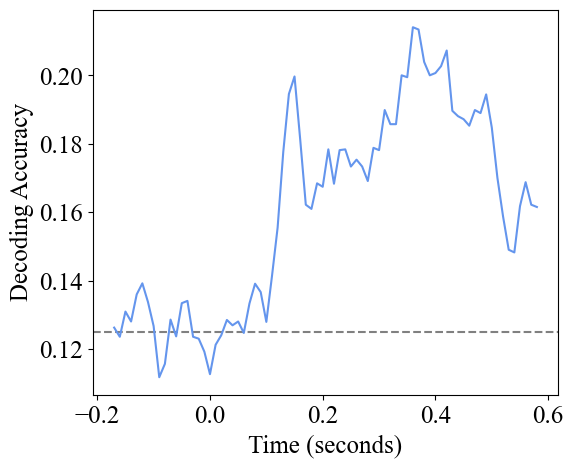

In [47]:
# Generate the time values
start_time = -.17
time_increment = .01
time_values = [start_time + i * time_increment for i in range(len(masterList))]
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Times New Roman'
# Create the plot
plt.figure(figsize=(6, 5))
plt.axhline(y=.125, color='grey', linestyle='--', label='chance')
plt.plot(time_values, decoding_peak, color = '#6495ED')

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Decoding Accuracy')


# Display the plot
plt.show()

In [26]:
#This function remaps the labels inside of decoding dictionaries to make them relative to a target, so that it can be averaged across cross-decoding results
#Wherein the target condition differs and the stills that appeared before and after it differ
def circularDict(correctCond, direction):
    #We know that in circular space this is the order of arrangement for conditions
    circularSpace = ['Back', '135_Left', 'Left', '45_Left', 'Center', '45_Right', 'Right', '135_Right']
    #Find where in the circular space the target condition is located
    index = circularSpace.index(correctCond)
    #create a new dictionary that will 
    new_dict = {}
    for i in range(len(circularSpace)):
        new_index = (index + i) % len(circularSpace)
        #If the movie is moving in opposite directions, what is before and after a target condition flips
        if direction == 'Left':
            label1 = 'after'
            label2 = 'before'
        else:
            label1 = 'before'
            label2 = 'after'
        distance = i
        if distance == 0:
            new_dict[circularSpace[new_index]] = 'target_cond'
        elif distance == 4:
            new_dict[circularSpace[new_index]] = 'opposite'
        elif distance < 4:
            new_dict[circularSpace[new_index]] = f'{distance}_{label2}'
        else:
            before_index = (index - (len(circularSpace) - i)) % len(circularSpace)
            if (len(circularSpace) - i) == 4:
                new_dict[circularSpace[before_index]] = 'opposite'
            else:
                new_dict[circularSpace[before_index]] = f'{len(circularSpace) - i}_{label1}'

    return new_dict

def remap_array(i, relabel_dict):
    return [relabel_dict.get(element, element) for element in i]

def relabelCond(decoding_list, relabel_dict):
    new_list = []
    for i in decoding_list:
        new_array = remap_array(i, relabel_dict)
        new_list.append(new_array)
    return new_list

ordered_conditions = ['Center', '45_Right', 'Right', '135_Right', 'Back', '135_Left', 'Left', '45_Left']

In [27]:
epochs_stackedMovie.times

array([-0.2       , -0.19916667, -0.19833333, ...,  3.19833333,
        3.19916667,  3.2       ])

In [28]:
standardized_dictList = []
for index, condition in enumerate(ordered_conditions):
    decoding_dict = decoding_dictList[index]
    standardized_dict = {}
    for movie, decoding_list in decoding_dict.items():
        underscore_pos = movie.find('_')
        direction = movie[underscore_pos + 1:]
        remap_dict = circularDict(condition, direction)
        new_list = relabelCond(decoding_list, remap_dict)
        standardized_dict[movie] = new_list
    standardized_dictList.append(standardized_dict)

In [29]:
print(standardized_dictList[1])

{'0067_Left': [['opposite', '1_after', 'target_cond', 'target_cond', '2_after', '3_before', 'opposite', '2_before', '3_before', 'opposite', '2_after', '2_after', '3_after', 'target_cond', 'opposite', '1_before', 'opposite', 'opposite', '2_after', '1_before', 'opposite', 'opposite', '1_before', '2_before', '2_after', '1_before', 'opposite', 'opposite'], ['opposite', 'opposite', '2_after', 'target_cond', '2_after', 'target_cond', 'opposite', '1_before', '1_before', 'opposite', '1_after', '2_after', '3_after', 'opposite', '1_before', '1_before', 'opposite', 'opposite', '1_before', 'opposite', '2_before', '1_before', '3_before', 'opposite', '2_before', '1_before', 'opposite', 'opposite'], ['opposite', 'opposite', '1_before', '1_before', '2_after', 'target_cond', '2_before', 'opposite', '1_before', 'opposite', '1_after', '2_after', '1_after', 'opposite', '3_after', 'opposite', 'target_cond', '3_after', '2_before', 'opposite', '2_before', '1_before', '3_before', 'opposite', '3_before', '1_be

In [30]:
from collections import defaultdict
average_proportionsList = []
for i in standardized_dictList:
    # Assuming predictions_dict is your dictionary where keys are items and values are lists of predictions
    # Initialize dictionaries to store counts and totals
    time_point_counts = defaultdict(lambda: defaultdict(int))
    time_point_totals = defaultdict(int)

    # Iterate through each item in the dictionary
    for item in i.values():
        # Iterate through each time point in the item
        for time_point, predictions_at_time in enumerate(item):
            # Count predictions at each time point
            for prediction in predictions_at_time:
                time_point_counts[time_point][prediction] += 1
                time_point_totals[time_point] += 1

    # Initialize dictionary to store average proportions
    average_proportions = defaultdict(dict)

    # Calculate proportions and average across all items
    for time_point in time_point_counts:
        for prediction, count in time_point_counts[time_point].items():
            proportion = count / time_point_totals[time_point]
            average_proportions[time_point][prediction] = proportion
    average_proportionsList.append(average_proportions)

    # Now average_proportions contains the average proportion of each prediction at each time point


In [32]:
average_proportions = average_proportionsList[0]

In [33]:
time_points = sorted(average_proportions.keys())
predictions = list(next(iter(average_proportions.values())).keys())

# Plotting each prediction as a separate line
plt.figure(figsize=(10, 6))

for prediction in predictions:
    proportions = [average_proportions[time_point][prediction] for time_point in time_points]
    plt.plot(time_points, proportions, label=prediction)

plt.xlabel('Time')
plt.ylabel('Proportion')
plt.title('Proportion of Predictions over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: '3_after'

<Figure size 1000x600 with 0 Axes>

In [34]:
print(len(average_proportionsList))

8


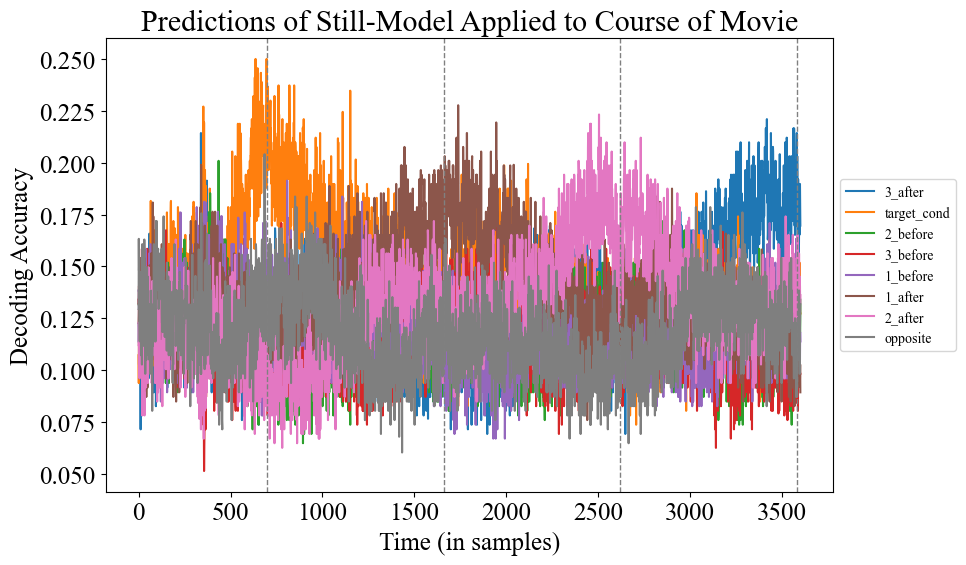

In [48]:
average_proportions_list = [average_proportionsList[0], average_proportionsList[1], average_proportionsList[2], average_proportionsList[3], average_proportionsList[4], average_proportionsList[5],
                            average_proportionsList[6], average_proportionsList[7]]


combined_proportions = defaultdict(lambda: defaultdict(list))

for average_proportions in average_proportions_list:
    for time_point, predictions in average_proportions.items():
        for prediction, proportion in predictions.items():
            combined_proportions[time_point][prediction].append(proportion)

# Calculate overall average proportions
overall_average_proportions = defaultdict(dict)

for time_point, predictions in combined_proportions.items():
    for prediction, proportions in predictions.items():
        average_proportion = sum(proportions) / len(proportions)
        overall_average_proportions[time_point][prediction] = average_proportion

# Extract predictions and time points
time_points = sorted(overall_average_proportions.keys())
predictions = list(next(iter(overall_average_proportions.values())).keys())



# Plotting each prediction as a separate line
plt.figure(figsize=(10, 6))


for prediction in predictions:
    proportions = [overall_average_proportions[time_point][prediction] for time_point in time_points]
    plt.plot(time_points, proportions, label=prediction)


plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Times New Roman'

plt.xlabel('Time (in samples)')
plt.ylabel('Decoding Accuracy')
# Adding vertical lines at specific x-coordinates
x_positions = [700, 1660, 2620, 3580] 
for x in x_positions:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
    
plt.title('Predictions of Still-Model Applied to Course of Movie')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

In [909]:
print(predictions)

['1_before', '2_after', 'target_cond', '3_after', '3_before', '1_after', '2_before', 'opposite']


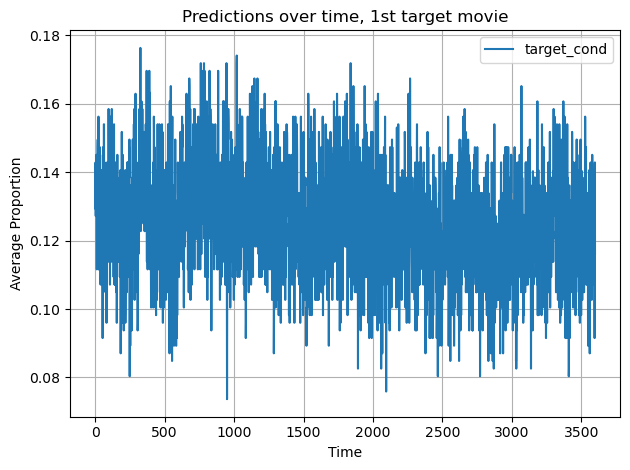

In [418]:

proportions = [overall_average_proportions[time_point]['target_cond'] for time_point in time_points]
plt.plot(time_points, proportions, label='target_cond')




plt.xlabel('Time')
plt.ylabel('Average Proportion')
plt.title('Predictions over time, 1st target movie')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [708]:
def calculate_proportion(array, target_string):
    # Count the occurrences of the target string
    target_count = np.sum(array == target_string)
    
    # Count the total number of elements in the array
    total_count = array.size
    
    # Calculate the proportion
    proportion = target_count / total_count if total_count > 0 else 0
    
    return proportion


In [709]:
runs = 8
condition = 'Right'

master_proportionlist = []
for run in range((runs)):
    current_run = decoding_list[run]
    proportion_list = []
    for timepoint in range(len(decoding_list[0])):
        proportion_list.append(calculate_proportion(decoding_list[run][timepoint], condition))
    master_proportionlist.append(proportion_list)

print(len(master_proportionlist[1]))


1000


In [710]:
import numpy as np

# Assuming master_proportionlist is already defined
def average_across_lists(master_proportionlist):
    # Transpose the list of lists
    transposed_list = list(map(list, zip(*master_proportionlist)))
    
    # Compute the average for each transposed sublist
    averaged_list = [np.mean(sublist) for sublist in transposed_list]
    
    return averaged_list

# Example usage
# master_proportionlist = [[...], [...], ...]  # Your list of lists
averaged_list = average_across_lists(master_proportionlist)

print(len(averaged_list))


1000


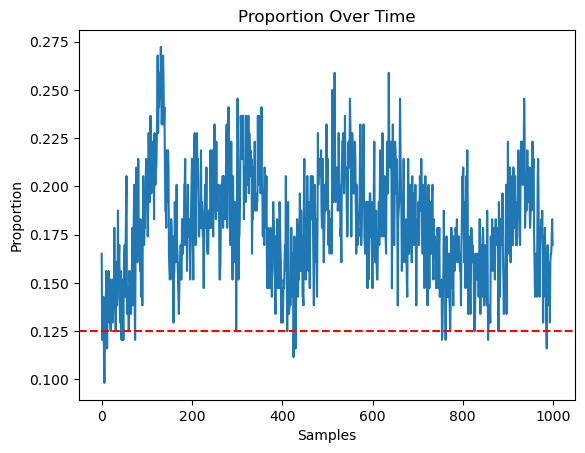

In [711]:
import matplotlib.pyplot as plt

# Create the x-axis values (time points)
time_points = list(range(len(averaged_list)))

# Plot the data
plt.plot(time_points, averaged_list)

# Add labels and title
plt.xlabel('Samples')
plt.ylabel('Proportion')
plt.title('Proportion Over Time')
plt.axhline(y=.125, color='r', linestyle='--')

# Display the plot
plt.show()

In [300]:
num_time_points = len(decoding_list[0])
proportions = []

for i in range(num_time_points):
    # Calculate the proportion of 'Right' for the current time point across all arrays
    right_count = sum(1 for predictions in decoding_list if predictions[i] == 'Right')
    total_count = len(decoding_list)
    proportion = right_count / total_count
    proportions.append(proportion)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [291]:
correct_answer = 'Right'

totalanswers = []
for i in decoding_list:
    answers = []
    for time in i:
        target_count = np.sum(time == target)
        total_count = numpy_array.size
        proportion = target_count / total_count
        answers.append(proportion)
    print(len(answers))
    totalanswers.append(answers)


AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [258]:
len(epochs_stackedMovie.times[4078:4080])

2

In [194]:

if specifyTime == True:
    res = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times)))
else:
    res = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times)))
   # res = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:,:,t],y_train,x_test[:,:,t]) for t in range(x_test.shape[2]))


#np.array(res).shape


In [197]:
train_cond = '0022_Left'

(4081, 449)


In [125]:
np.array(res)[:,[i=='0022_Right' for i in y_test]]

print(len(np.array(res)[:,[i=='0022_Right' for i in y_test]]))

4081


In [ ]:
predictions = np.array(res)[:,[i==train_cond for i in y_test]]

In [ ]:


possible_labels = np.unique(predictions)

prediction_proportions=[]
for t in range(predictions.shape[0]):
    prediction_proportions.append([list(predictions[t,:]).count(p)/predictions.shape[1] for p in possible_labels])

In [ ]:
[plt.plot(epochs_stackedMovie.times[::15], np.array(prediction_proportions)[:,p_i][::15], label = p, alpha = .8) for p_i, p in enumerate(possible_labels)]
plt.legend()

/Users/montesinossl/anaconda3/envs/mne2/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/montesinossl/anaconda3/envs/mne2/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (961,) and (1,)

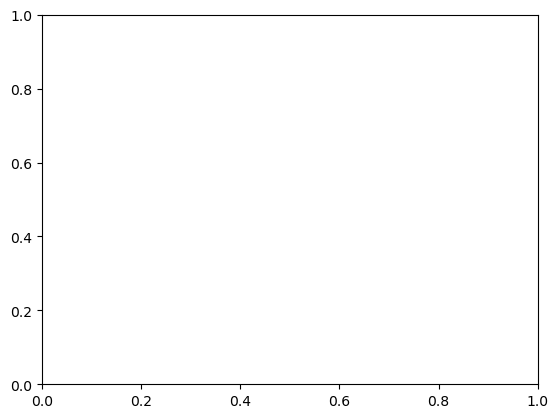

In [86]:
def create_numerical_predictions(res,y_test,condition_of_interest):
    stimulus_mapping = {'Left':-2, '45_Left': -1, 'Center':0,'45_Right':1, 'Right':2}
    predictions = np.array(res)[:,[i==condition_of_interest for i in y_test]]
    predictions_numeric = np.array([[stimulus_mapping[i] for i in predictions[:,trial]] for trial in range(predictions.shape[1])])
    return predictions_numeric

toplot1 = create_numerical_predictions(res,y_test,'Left_Center')
toplot2 = create_numerical_predictions(res,y_test,'Center_Left')

plt.plot(epochs_selected.times, np.mean(toplot1,axis=0),label='Left_Center',alpha=0.5)
plt.plot(epochs_selected.times, np.mean(toplot2,axis=0),label='Center_Left',alpha=0.5)
plt.legend()





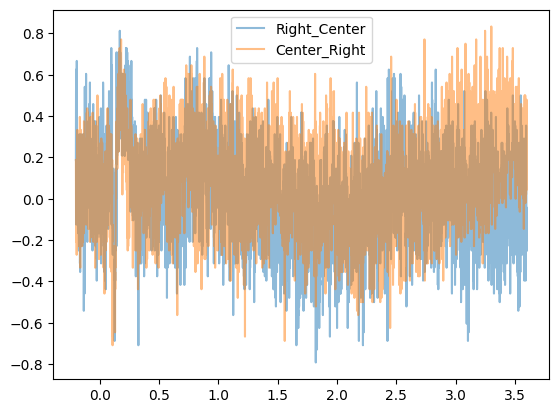

In [313]:
toplot1 = create_numerical_predictions(res,y_test,'Right_Center')
toplot2 = create_numerical_predictions(res,y_test,'Center_Right')

plt.plot(epochs_selected.times, np.mean(toplot1,axis=0),label='Right_Center',alpha=0.5)
plt.plot(epochs_selected.times, np.mean(toplot2,axis=0),label='Center_Right',alpha=0.5)
plt.legend()

In [123]:
res.shape()

AttributeError: 'list' object has no attribute 'shape'

In [199]:
conditions_of_interest = ['45_Right', 'Right', '135_Right', 'Back']
#predictions = np.array(res)[:,[i==condition_of_interest for i in y_test]]

def createProportionDict(test_cond, train_cond):
    predictions = np.array(res)[:,[i==train_cond for i in y_test]]
    proportionDict = {condition: [] for condition in test_cond}
    for i in range(len(predictions)):
        currentTime = predictions[i]
        for condition in test_cond:
            condition_count = np.sum(currentTime == condition)
            condition_proportion = condition_count/len(currentTime)
            proportionDict[condition].append(condition_proportion)
    return proportionDict
        
def smoothDict(dictionary, window_size=10):
    smoothed_dict = {}
    
    for condition, values in dictionary.items():
        smoothed_values = []
        for i in range(len(values)):
            start = max(0, i - window_size)
            end = min(len(values), i + window_size + 1)
            average = sum(values[start:end]) / len(values[start:end])
            smoothed_values.append(average)
        smoothed_dict[condition] = smoothed_values
    
    return smoothed_dict




def createProportionGraph(proportionDict, conditions_of_interest, title):
    print(conditions_of_interest)
    for condition in conditions_of_interest:
        if condition in proportionDict:
            plt.plot(epochs_stackedMovie.times, proportionDict[condition], label = condition, alpha = .8)
    plt.xlabel('Time')
    plt.ylabel('Proportion')
    plt.title(title)
    plt.legend()
    plt.show()



#tst = createProportionDict(['Center', '45_Right', 'Right', '135_Right', 'Back', '45_Left', 'Left', '135_Left'], '0022_Left')
tst = createProportionDict(['45_Right', 'Right', '135_Right', 'Back'], '0022_Right')
tst2 = smoothDict(tst)

In [204]:
print((y_test == '0022_Right').sum())

28


In [245]:
predictions.shape

(4081, 29)

In [241]:
train_cond = '0022_Left'

In [242]:
predictions = np.array(res)[:,[i==train_cond for i in y_test]]

In [243]:


possible_labels = np.unique(predictions)

prediction_proportions=[]
for t in range(predictions.shape[0]):
    prediction_proportions.append([list(predictions[t,:]).count(p)/predictions.shape[1] for p in possible_labels])

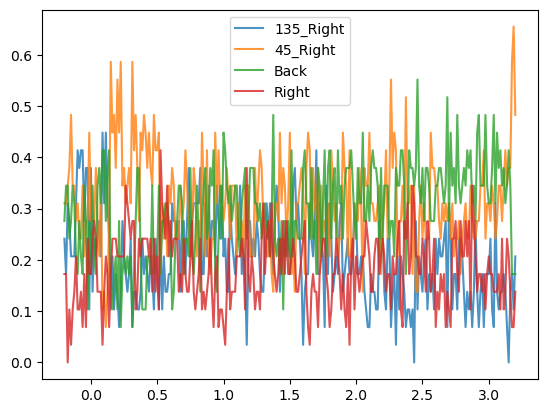

In [244]:
[plt.plot(epochs_stackedMovie.times[::15], np.array(prediction_proportions)[:,p_i][::15], label = p, alpha = .8) for p_i, p in enumerate(possible_labels)]
plt.legend()

In [239]:
prediction_proportions

[[0.25, 0.35714285714285715, 0.14285714285714285, 0.25],
 [0.25, 0.35714285714285715, 0.14285714285714285, 0.25],
 [0.39285714285714285, 0.25, 0.14285714285714285, 0.21428571428571427],
 [0.2857142857142857, 0.2857142857142857, 0.17857142857142858, 0.25],
 [0.2857142857142857, 0.25, 0.14285714285714285, 0.32142857142857145],
 [0.25, 0.21428571428571427, 0.2857142857142857, 0.25],
 [0.17857142857142858,
  0.4642857142857143,
  0.21428571428571427,
  0.14285714285714285],
 [0.21428571428571427, 0.5, 0.17857142857142858, 0.10714285714285714],
 [0.21428571428571427,
  0.4642857142857143,
  0.10714285714285714,
  0.21428571428571427],
 [0.2857142857142857,
  0.35714285714285715,
  0.17857142857142858,
  0.17857142857142858],
 [0.14285714285714285,
  0.4642857142857143,
  0.10714285714285714,
  0.2857142857142857],
 [0.2857142857142857,
  0.42857142857142855,
  0.07142857142857142,
  0.21428571428571427],
 [0.21428571428571427,
  0.4642857142857143,
  0.14285714285714285,
  0.178571428571428

In [119]:
print(tst2)

{'0': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

['45_Right', 'Right', '135_Right', 'Back']


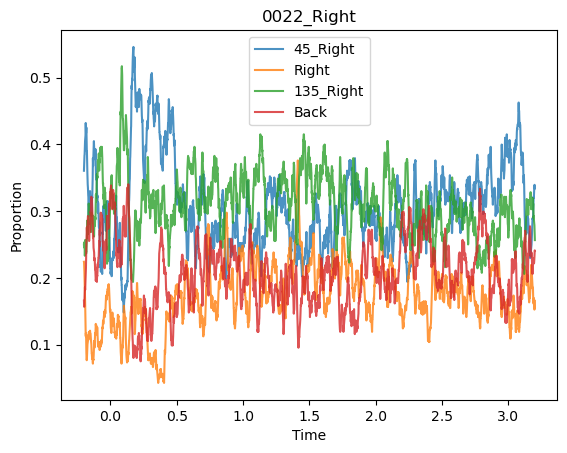

In [200]:
conditions_of_interest = ['45_Right', 'Right', '135_Right', 'Back']
createProportionGraph(tst2, conditions_of_interest, '0022_Right')

In [ ]:
import numpy as np

n_time_points = len(epochs_stacked.times)
results_matrix = np.zeros((n_time_points, n_time_points, len(np.unique(epochs_selected.metadata.run_nr))))

def compute_accuracy(t, epochs_selected, test_run):
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected, test_run)
    return run_decoding(x_train[:,:,t], y_train, x_test[:,:,t], y_test)


for test_run_id, test_run in enumerate(np.unique(epochs_selected.metadata.run_nr)):
     results = Parallel(n_jobs=12, prefer="threads")(
        delayed(compute_accuracy)(t, epochs_selected, test_run) for t in range(len(epochs_stacked.times))
    )
     for t, accuracy in enumerate(results):
        results_matrix[t, test_run_id] = accuracy
                          



    


In [ ]:
epochs_stacked.metadata

In [ ]:
train_test_column = 'block_type'
test_column_label = 'Watch_Still'
condition_column = 'condition'
test_conditions = ['Left','Right']

epochs_stacked[epochs_stacked.metadata[train_test_column] == test_column_label and np.any([epochs_stacked.metadata[condition_column] == i for i in test_conditions],axis=0)]

In [ ]:
import numpy as np
import pandas as pd
import glob
import pickle
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut, StratifiedKFold

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,cross_val_multiscore,get_coef)

#*****************************#
### PARAMETERS ###
#*****************************#
n_jobs = 16
cv = LeaveOneGroupOut()


def build_svm():
    clsfy_pipeline = make_pipeline(StandardScaler(), svm.SVC(kernel='linear',C=1))
    time_decod = SlidingEstimator(clsfy_pipeline, n_jobs=n_jobs, scoring='accuracy', verbose=True)
    return time_decod

def run_decoding(X,y,cv,groups):
    clsfy_pipeline = make_pipeline(StandardScaler(), svm.SVC(kernel='linear',C=1))
    time_decod = SlidingEstimator(clsfy_pipeline, n_jobs=n_jobs, scoring='accuracy', verbose=True)
    scores = cross_val_multiscore(time_decod, X, y, cv=cv, n_jobs=n_jobs, pre_dispatch='1*n_jobs',groups = groups)
    return scores

X = epochs_stacked._data
np.shape(X)
#print(X)

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where((conds >0) & (conds < 6))] = 1
tmp[np.where((conds >5) & (conds < 10))] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 72
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)

plt.plot(groups)

In [ ]:
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Still v Dynamic")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 1)] = 1
tmp[np.where(conds == 3)] = 2
tmp[np.where(conds == 5)] = 3
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 24
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Within Still")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 6)] = 1
tmp[np.where(conds == 7)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Left-Center vs Right-Center")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 8)] = 1
tmp[np.where(conds == 9)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Center-Left vs Center-Right")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 8)] = 1
tmp[np.where(conds == 6)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Center-Left vs Left-Center")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 7)] = 1
tmp[np.where(conds == 9)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Center-Left vs Left-Center")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 8)] = 1
tmp[np.where(conds == 1)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Center-Left vs Left")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
print(conds)
tmp[np.where(conds == 6)] = 1
tmp[np.where(conds == 2)] = 2
print(tmp)
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)
scoresWSvsIS = run_decoding(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresWSvsIS_mean = np.mean(scoresWSvsIS,0)
plt.title("Left-Center vs Left")
plt.plot(scoresWSvsIS_mean[::])

In [ ]:
def run_tempgen(X,y,cv,groups):
    clsfy_pipeline = make_pipeline(StandardScaler(), svm.SVC(kernel='linear',C=1))
    time_decod = GeneralizingEstimator(clsfy_pipeline, n_jobs=n_jobs, scoring='accuracy', verbose=True)
    scores = cross_val_multiscore(time_decod, X, y, cv=cv, n_jobs=n_jobs, pre_dispatch='1*n_jobs',groups = groups)
    return scores
ntimes = 4201
xmin = -200
xmax = 3300
xvals = np.linspace(xmin,xmax,ntimes)
def save_plot2(scores, title, X, Y, chance):
    # Define a fixed color scale range from -1 to 1
    if chance == .5:
        vmin, vmax = 0.1, .9
    else:
        vmin, vmax = 0, 2/3
    # Plot using imshow with the fixed color scale
    plt.imshow(scores, extent=xvals[[0, -1, 0, -1]], origin='lower', cmap='RdBu_r', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    plt.colorbar()
    plt.axvline(0, color='k')
    plt.axhline(0, color='k')
    plt.legend()
    plt.xlabel(X, fontsize=16)
    plt.ylabel(Y, fontsize=16)
    plt.title(title)
    plt.savefig(f'{title}.png')

In [ ]:
tmp = np.zeros(len(X))
conds = []
for i in all_events:
    conds.extend(i[:,2])
conds = np.array(conds)
tmp[np.where((conds == 6))] = 1
tmp[np.where((conds == 8))] = 2
y = tmp
groups = np.zeros(len(X))
group_size = 6
trials_per_group = 16
#setup the groups array
pattern = np.arange(1, group_size + 1)
# Create the array by repeating the pattern
groups = np.repeat(pattern, trials_per_group)


scoresLVCTemp = run_tempgen(X[tmp!=0,:,:],y[tmp!=0],cv, groups)
scoresTempmean = np.mean(scoresLVCTemp,0)

from matplotlib import colors
save_plot2(scoresTempmean, 'Center-Left v Left-Center', 'Testing Time', 'Training Time', 1/2)